# Project 2, Part 7, Executive summary

University of California, Berkeley

Master of Information and Data Science (MIDS) program

w205 - Fundamentals of Data Engineering

Student: Landon Morin

Year: 2022

Semester: Spring

Section: 9


# Included Modules and Packages

Code cell containing your includes for modules and packages

In [63]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import psycopg2

import json

import csv


import gmaps
import gmaps.geojson_geometries

from geographiclib.geodesic import Geodesic

from datetime import datetime as dt

from IPython.display import display, HTML

# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  

Remember you can freely use any code from the labs. You do not need to cite code from the labs.

In [64]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

In [65]:
cursor = connection.cursor()

In [66]:
#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)
    

# 2.7.1 Executive summary

Write an executive summary.  

The summary should be the equivalent to 3/4 to 1 page using standard fonts, spacing, and margins. 

You may write about any aspect (or aspects).  Basically figure out what you think is the most import aspect (or aspects) that the executives would want to know.  

It could be related to the process itself. Such as how you were able to take a dataset, load it into staging tables, and get analytics very quickly, instead of a months long traditional waterfall process. 

It could be related to the preliminary analytics.  Any insights you gained.  Possible comparison to the analytics from project 1.  Do the delivery sales have different patterns or the same patterns as in store sales?  Is this a good way to grow sales? etc.

It could be related to both.

You are not required to write any queries nor create any data visualizations.  However, you may want to include some to enhance and add quality to your submission.  Submissions with these tend to be higher quality, although, not always.

You may use any number of code cells and/or markdown cells. 

You may alternate between code cells and markdown cells.  That is perfectly fine.  It is understood that before we present it, an editor would pull out the text, results of queries, and data visualizations.

In [67]:
rollback_before_flag = True
rollback_after_flag = True

query = """

with a as (select count(distinct(c.customer_id)) as total_customers_within5
           from customers as c
               join stores as s
                   on c.closest_store_id = s.store_id
           where c.distance < 6 and s.city = 'Berkeley'),
        
b as (select count(distinct(customer_id)) as total_customers
      from customers as c
            join stores as s
                on c.closest_store_id = s.store_id
      where s.city = 'Berkeley')

select a.total_customers_within5, b.total_customers,
       round(a.total_customers_within5::numeric/b.total_customers::numeric*100,1) as pct_customers_within5
from a,b


"""

customers_within_5 = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
customers_within_5

,total_customers_within5,total_customers,pct_customers_within5
0,3448,8138,42.4


In [68]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select count(customer_id) as total_customers, 
       distance as distance_from_store
from customers as c
            join stores as s
                on c.closest_store_id = s.store_id
where s.city = 'Berkeley'
group by distance
order by distance desc

"""

distance_from_berkeley = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
distance_from_berkeley

,total_customers,distance_from_store
0,29,25
1,10,24
2,26,23
3,44,22
4,48,21
5,20,20
6,33,19
7,36,18
8,28,17
9,41,16


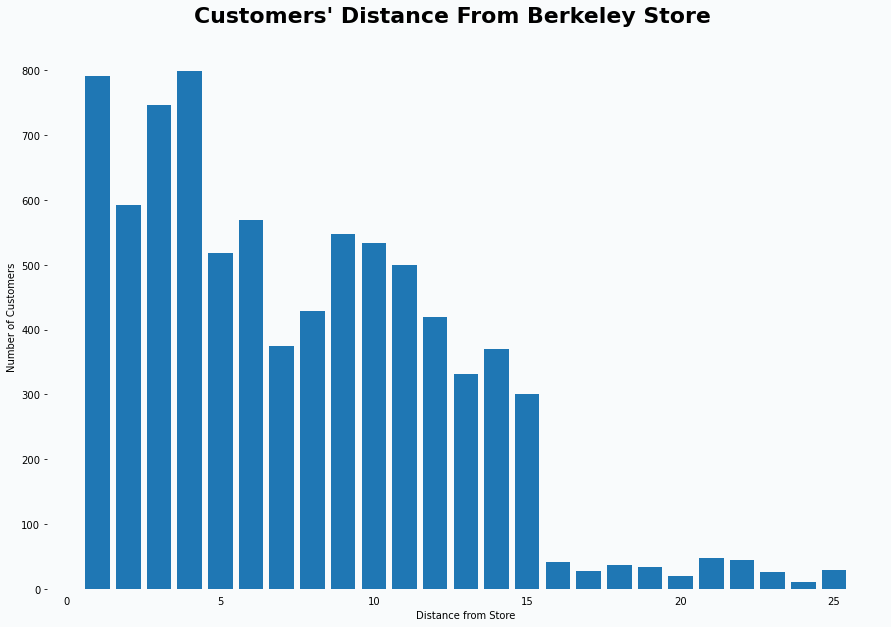

In [69]:
fig, ax = plt.subplots(figsize=(15,10))
ax.bar(distance_from_berkeley['distance_from_store'], distance_from_berkeley['total_customers'])
ax.tick_params(bottom=False)
ax.set_frame_on(False)
plt.xlabel('Distance from Store')
plt.ylabel('Number of Customers')
fig.text(
    x=0.5, 
    y=0.92,
    s="Customers' Distance From Berkeley Store",
    ha="center",
    va="center",
    ma="center",
    fontsize=22,
    fontweight="bold",
)

fig.set_facecolor("#f9fbfc")


In [70]:
rollback_before_flag = True
rollback_after_flag = True

query = """

with a as (select sum(sa.total_amount) as total_revenue_in_5miles, 
                  count(distinct(sa.sale_id)) as total_sales_in_5miles
           from sales as sa
               join customers as c
                   on sa.customer_id = c.customer_id
               join stores as s
                   on s.store_id = c.closest_store_id
           where distance < 6 and s.city = 'Berkeley'),
        
b as (select sum(sa.total_amount) as total_revenue,
             count(distinct(sa.sale_id)) as total_sales
           from sales as sa
               join customers as c
                   on sa.customer_id = c.customer_id
               join stores as s
                   on s.store_id = c.closest_store_id
           where s.city = 'Berkeley')

select a.total_revenue_in_5miles,
       a.total_sales_in_5miles,
       b.total_revenue,
       b.total_sales,
       round(a.total_revenue_in_5miles::numeric/b.total_revenue::numeric*100,1) as pct_revenue_in_5miles,
       round(a.total_sales_in_5miles::numeric/b.total_sales::numeric*100,1) as pct_sales_in_5miles
from a,b


"""

in_delivery_range = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
in_delivery_range

,total_revenue_in_5miles,total_sales_in_5miles,total_revenue,total_sales,pct_revenue_in_5miles,pct_sales_in_5miles
0,13035252,214238,25041060,390375,52.1,54.9


In [71]:
rollback_before_flag = True
rollback_after_flag = True

query = """

with a as (select sum(sa.total_amount) as total_revenue_within5, 
                  count(distinct(sa.sale_id)) as total_sales_within5
           from sales as sa
               join customers as c
                   on sa.customer_id = c.customer_id
               join stores as s
                   on s.store_id = c.closest_store_id
           where distance < 6 and s.city = 'Berkeley')

select round(a.total_revenue_within5::numeric/count(distinct(sa.sale_date)),1) as avg_daily_revenue_in_5miles,
       round(a.total_sales_within5::numeric/count(distinct(sa.sale_date)),1) as avg_daily_sales_in_5miles
from a, sales as sa
group by a.total_revenue_within5, a.total_sales_within5

"""

avg_daily_sales = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
avg_daily_sales

,avg_daily_revenue_in_5miles,avg_daily_sales_in_5miles
0,35811.1,588.6


In [72]:
rollback_before_flag = True
rollback_after_flag = True

query = """

with a as (select sum(sa.total_amount) as total_revenue_oct3, 
                  count(distinct(sa.sale_id)) as total_sales_oct3
           from sales as sa
               join customers as c
                   on sa.customer_id = c.customer_id
               join stores as s
                   on s.store_id = c.closest_store_id
           where sa.sale_date = '2020-10-03' and s.city = 'Berkeley'),
           
b as (select sum(total_amount::numeric) as total_sales,
             round(sum(total_amount::numeric)*.18, 2) as cut_to_peak,
             round((sum(total_amount::numeric) - sum(total_amount::numeric)*.18), 2) as net_to_agm_oct3
      from stage_1_peak_sales)

select a.total_revenue_oct3 as total_revenue_no_delivery,
       a.total_sales_oct3 as total_sales_no_delivery,
       b.net_to_agm_oct3,
       a.total_revenue_oct3::numeric + b.net_to_agm_oct3 as total_revenue_with_delivery,
       round(((a.total_revenue_oct3::numeric + b.net_to_agm_oct3) - a.total_revenue_oct3::numeric)/
       a.total_revenue_oct3::numeric*100,1) as peak_revenue_pct_total_oct3_peakagm
from a,b


"""

total_daily_sales = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
total_daily_sales

,total_revenue_no_delivery,total_sales_no_delivery,net_to_agm_oct3,total_revenue_with_delivery,peak_revenue_pct_total_oct3_peakagm
0,96708,1558,5313.6,102021.6,5.5


In [73]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select c.customer_id as customer, 
       c.distance as distance_from_store, 
       count(distinct(sa.sale_id, sa.store_id)) as total_visits, 
       sum(l.quantity) as total_meals,
       sum(sa.total_amount) as total_sales
from stores as s
    left join customers as c
        on c.closest_store_id = s.store_id
    left join sales as sa
        on c.customer_id = sa.customer_id
    left join line_items as l
        on l.sale_id = sa.sale_id
where s.city = 'Berkeley'
group by c.customer_id, s.city
order by total_sales

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,customer,distance_from_store,total_visits,total_meals,total_sales
0,1528,3,16,273,7536
1,105,1,17,234,7932
2,6485,12,9,191,8256
3,1757,3,17,340,9432
4,961,2,22,411,10596
...,...,...,...,...,...
8133,295,1,1,<NA>,<NA>
8134,7600,15,1,<NA>,<NA>
8135,5148,9,1,<NA>,<NA>
8136,2000,3,1,<NA>,<NA>


In [74]:
df = df.fillna(0)
df['total_sales'] = df['total_sales'].astype(float)
df['total_visits'] = df['total_visits'].astype(float)

In [75]:
def thousands_formatter(x, pos):
    return f'${x / 1000}'

In [76]:
#Creating bins for distance from store.
min_value = df['distance_from_store'].min()
max_value = df['distance_from_store'].max()

bins = np.linspace(min_value,max_value,5)

labels = ['1-6 Miles', '7-12 Miles', '13-18 Miles', '19-25 Miles']
df['bins'] = pd.cut(df['distance_from_store'], bins=bins, labels=labels, include_lowest=True)

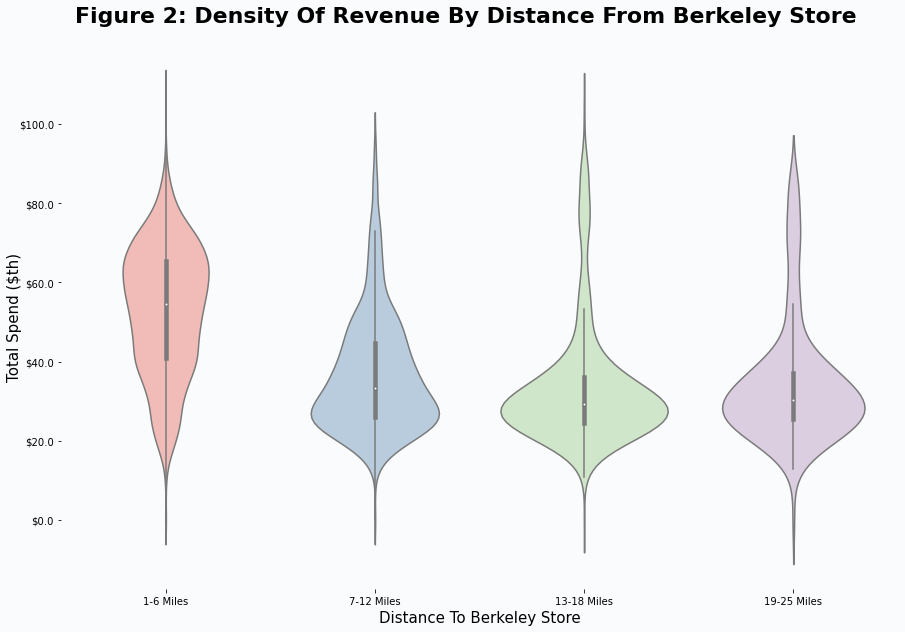

In [77]:
#Plotting distance from store violin plot.
fig, ax = plt.subplots(figsize=(15, 10))

sns.violinplot(x="bins", 
               y="total_sales", 
               data=df, 
               palette="Pastel1",
               ax=ax, 
               labels = False)

ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
ax.set_frame_on(False)


# Add titles (main and on axis)
plt.xlabel('Distance To Berkeley Store', ha='center', fontsize = 15)
plt.ylabel('Total Spend ($th)', va='center', rotation='vertical', fontsize = 15)
fig.text(
    x=0.5, 
    y=0.92,
    s="Figure 2: Density Of Revenue By Distance From Berkeley Store",
    ha="center",
    va="center",
    ma="center",
    fontsize=22,
    fontweight="bold"
)

fig.set_facecolor("#f9fbfc")



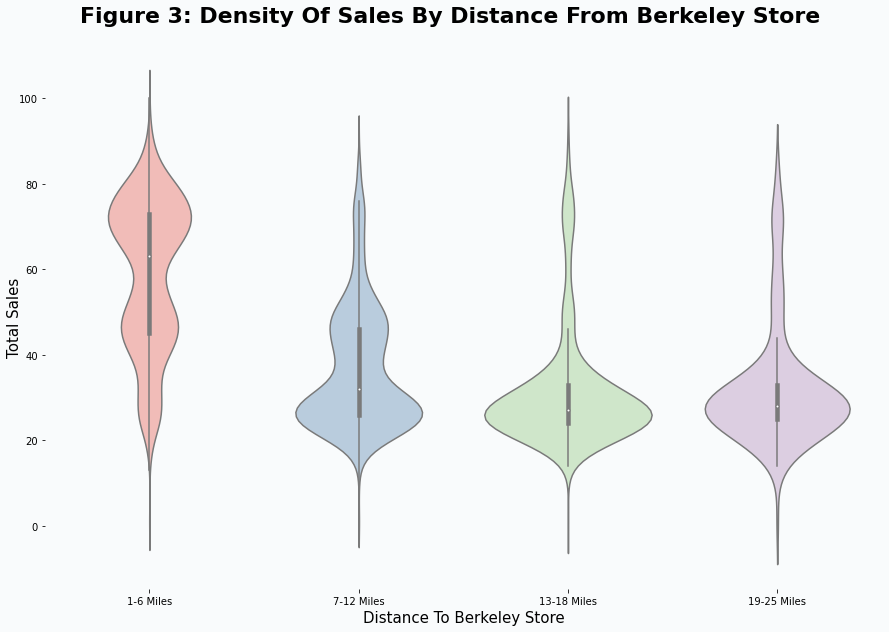

In [78]:
#Plotting distance from store violin plot.
fig, ax = plt.subplots(figsize=(15, 10))

sns.violinplot(x="bins", 
               y="total_visits", 
               data=df, 
               palette="Pastel1",
               ax=ax, 
               labels = False)


ax.set_frame_on(False)


# Add titles (main and on axis)
plt.xlabel('Distance To Berkeley Store', ha='center', fontsize = 15)
plt.ylabel('Total Sales', va='center', rotation='vertical', fontsize = 15)
fig.text(
    x=0.5, 
    y=0.92,
    s="Figure 3: Density Of Sales By Distance From Berkeley Store",
    ha="center",
    va="center",
    ma="center",
    fontsize=22,
    fontweight="bold"
)

fig.set_facecolor("#f9fbfc")


# Executive Summary

Our data engineering team has developed a solid framework for ELT and OI/OD processes for Peak's incoming data. Rather than construct a large and inflexible waterfall process, our team has been able to load data into temporary tables to cleanse, wrangle, and analyse. Furthermore, our team is confident that we can replicate this process, integrate new data using this process, and improve upon this process quickly. In just a few hours, our team has cleansed Peak's data, which is now able to be integrated with ours. 

Our ELT process has parsed Peak's data, and validated their sales mathematics, customer names and addresses, data types, product mapping, and more. 

Additionally, our team has performed analytics on AGM's first trial day with Peak. Our analyses do not provide insight into the future profitability of partnering with Peak. However, it does provide us with interesting considerations. 

Consider the AGM customer profile. 42\% of AGM's Berkeley shoppers live within 5 miles of the store. These shoppers spend \\$13,035,252 annually and conduct 214,238 sales. This means that 52\% of our Berkeley revenue currently comes from customers less than 5 miles away and 54\% of our sales comes from these same customers. Our analysis shows that customers who are further away make fewer trips to the store, and we receive less revenue from them. 

On our first trial day with Peak, 5.5\% of our sales were through Peak. This means that for 5.5\% of our sales, we absorbed an 18\% revenue cut, since our customer analysis shows that we acquired no new customers. It is possible that our partnership with Peak will bring us new customers, however, our team questions whether we should restrict deliveries to our customers who are closest to our store. 

Customers in close proximity have proven to spend more, and visit our store more. Therefore, we should prioritize getting these customers into our store. These customers will allow us to avoid Peak's 18\% cut. 

Peak's services can be valuable, and the 18\% cut will be worth it in two scenarios: (1) Peak Delivery allows us to acquire new customers in a 5 mile radius who would not otherwise have visited our store or (2) AGM partners with a delivery organization that will deliver to our furthest customers. 

Our analysts advocate for the second option, as this will allow us to tap into new revenue streams that have historically been difficult. Customers further away can or will not come to us. We can benefit ourselves and our customers by bringing our products to them. 










